In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sb
import missingno as mn
from datetime import datetime, timedelta
from functools import reduce
import importlib
from time import time
from tqdm import tqdm
plt.style.use("classic")
import my_functions_v6 as my
from sklearn import linear_model as lm
import statsmodels.api as sm

importlib.reload(my)


<module 'my_functions_v6' from '/Users/lucasumann/PycharmProjects/Masterarbeit/Notebooks/my_functions_v6.py'>

V3: fake volumes are not completely excluded, only single observations
illiquidity fix also

# This version implements the data fixes for the returns before the features are engineered

# Read Price Data

In [2]:
price_files = os.listdir("../Cryptocompare data/Prices")

In [3]:
prices = dict(
    zip(
        [file[:-4] for file in price_files if file[-4:] == ".csv"],
        [pd.read_csv("../Cryptocompare data/Prices/" + file, index_col= "Unnamed: 0") for file in price_files if file[-4:] == ".csv"]
    )
)

In [4]:
# Calculate daily returns
for coin in prices.keys():
    prices[coin]["daily return"] = prices[coin]["close"].pct_change()

In [5]:
prices["BTC"]

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timestamp,daily return
0,1279324800,0.04951,0.04951,0.04951,20.00,9.902000e-01,0.04951,direct,NaN,2010-07-17 02:00:00,NaN
1,1279411200,0.08585,0.05941,0.04951,75.01,5.092000e+00,0.08584,direct,NaN,2010-07-18 02:00:00,0.733791
2,1279497600,0.09307,0.07723,0.08584,574.00,4.966000e+01,0.08080,direct,NaN,2010-07-19 02:00:00,-0.058714
3,1279584000,0.08181,0.07426,0.08080,262.00,2.059000e+01,0.07474,direct,NaN,2010-07-20 02:00:00,-0.075000
4,1279670400,0.07921,0.06634,0.07474,575.00,4.226000e+01,0.07921,direct,NaN,2010-07-21 02:00:00,0.059807
...,...,...,...,...,...,...,...,...,...,...,...
4437,1662681600,21559.78000,19299.24000,19321.77000,79722.17,1.657848e+09,21369.73000,direct,NaN,2022-09-09 02:00:00,0.105992
4438,1662768000,21807.62000,21138.54000,21369.73000,35129.91,7.529051e+08,21655.13000,direct,NaN,2022-09-10 02:00:00,0.013355
4439,1662854400,21850.77000,21366.74000,21655.13000,27756.78,6.000082e+08,21836.45000,direct,NaN,2022-09-11 02:00:00,0.008373
4440,1662940800,22482.54000,21567.71000,21836.45000,57121.32,1.264511e+09,22400.52000,direct,NaN,2022-09-12 02:00:00,0.025832


# Read Covariates

In [6]:
blockchain_data_files = os.listdir("../Cryptocompare data/Blockchain Data")

In [7]:
blockchain_data = dict(
    zip(
        [file[:-4] for file in price_files if file[-4:] == ".csv"],
        [pd.read_csv("../Cryptocompare data/Blockchain Data/" + file, index_col= "Unnamed: 0") for file in blockchain_data_files if file[-4:] == ".csv"]
    )
)

In [8]:
for key in blockchain_data.keys():
    df = blockchain_data[key]
    df.index = [datetime.fromtimestamp(time) for time in df.time]
    del df["id"]
    del df["symbol"]
    del df["time"]
    blockchain_data[key] = df

# Combine price and blockchain data

We only keep days for which we have both the price and blockchain information.
We join information by day.

In [9]:
aggregate_data = {}

for key in prices.keys():
    price = prices[key]
    covariates = blockchain_data[key]

    price["day"] = [str(time)[:10] for time in price.timestamp]
    covariates["day"] = [str(id)[:10] for id in covariates.index]

    aggregate = pd.merge(left = price, right = covariates, left_on="day", right_on="day", how = "inner")
    aggregate.index = pd.to_datetime(aggregate["day"])

    del aggregate["day"]
    aggregate_data[key] = aggregate

In [10]:
# Keep only after 2017
for coin in aggregate_data.keys():
    aggregate_data[coin] = aggregate_data[coin][pd.to_datetime("2017-01-01"):pd.to_datetime("2022-03-01")]

In [11]:
len(aggregate_data)

678

# Load T-rate yields

In [12]:
yield_files = os.listdir("../Daily Treasury Par Yield Curve Rates")
treasury_yield_rates = pd.concat(
        [pd.read_csv("../Daily Treasury Par Yield Curve Rates/" + file, index_col= "Date") for file in yield_files if file[-4:] == ".csv"]
    )


In [13]:
treasury_yield_rates.head()



,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,,,
12/31/2020,0.08,0.08,0.09,0.09,0.10,0.13,0.17,0.36,0.65,0.93,1.45,1.65
12/30/2020,0.06,0.06,0.08,0.09,0.12,0.12,0.17,0.37,0.66,0.93,1.46,1.66
12/29/2020,0.08,0.09,0.10,0.12,0.11,0.12,0.17,0.37,0.66,0.94,1.47,1.67
12/28/2020,0.09,0.10,0.11,0.11,0.11,0.13,0.17,0.38,0.65,0.94,1.46,1.67
12/24/2020,0.09,0.09,0.09,0.09,0.10,0.13,0.17,0.37,0.66,0.94,1.46,1.66


In [14]:
# As we can see, the format of the dates is different from the one we use in our other datasets, so we will equalize it

treasury_yield_rates.index = [date[-4:] + "-" + date[:2] + "-" + date[3:5] for date in list(treasury_yield_rates.index)]



In [15]:
treasury_yield_rates = treasury_yield_rates.sort_index()

In [16]:
treasury_yield_rates

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
2010-01-04,0.05,NaN,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.60,4.65
2010-01-05,0.03,NaN,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2010-01-06,0.03,NaN,0.06,0.15,0.40,1.01,1.60,2.60,3.33,3.85,4.63,4.70
2010-01-07,0.02,NaN,0.05,0.16,0.40,1.03,1.62,2.62,3.33,3.85,4.62,4.69
2010-01-08,0.02,NaN,0.05,0.15,0.37,0.96,1.56,2.57,3.31,3.83,4.61,4.70
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-06,2.44,2.82,3.04,3.40,3.61,3.50,3.55,3.43,3.41,3.33,3.74,3.49
2022-09-07,2.30,2.80,3.07,3.42,3.60,3.45,3.50,3.37,3.35,3.27,3.67,3.42
2022-09-08,2.57,2.86,3.06,3.44,3.60,3.48,3.54,3.39,3.37,3.29,3.69,3.45
2022-09-09,2.57,2.88,3.08,3.52,3.67,3.56,3.61,3.45,3.42,3.33,3.71,3.47


In [17]:
# On the weekends and some other days there is no data. We just copy the last known value
days = treasury_yield_rates.index.to_numpy()
days = pd.to_datetime(days)

# All days between first and last day
idx = pd.date_range(days[0], days[-1])

# Reindex
treasury_yield_rates.index = pd.to_datetime(treasury_yield_rates.index)
treasury_yield_rates = treasury_yield_rates.reindex(idx, method = "ffill")

In [18]:
treasury_yield_rates.tail()

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
2022-09-08,2.57,2.86,3.06,3.44,3.60,3.48,3.54,3.39,3.37,3.29,3.69,3.45
2022-09-09,2.57,2.88,3.08,3.52,3.67,3.56,3.61,3.45,3.42,3.33,3.71,3.47
2022-09-10,2.57,2.88,3.08,3.52,3.67,3.56,3.61,3.45,3.42,3.33,3.71,3.47
2022-09-11,2.57,2.88,3.08,3.52,3.67,3.56,3.61,3.45,3.42,3.33,3.71,3.47
2022-09-12,2.62,2.93,3.17,3.56,3.70,3.58,3.60,3.47,3.45,3.37,3.76,3.53


# Calculate excess returns for every coin

In [19]:
for coin in aggregate_data.keys():
    aggregate_data[coin]["daily excess return"] = aggregate_data[coin]["daily return"].sub(treasury_yield_rates["1 Mo"]/100, axis = "index")

/var/folders/13/d37n485s17n292n_3yvvjbw00000gn/T/ipykernel_27360/2036596769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggregate_data[coin]["daily excess return"] = aggregate_data[coin]["daily return"].sub(treasury_yield_rates["1 Mo"]/100, axis = "index")


In [20]:
aggregate_data["BTC"]

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timestamp,...,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply,daily excess return
day,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1483228800,1001.61,956.10,963.38,41148.52,4.057092e+07,995.44,direct,NaN,2017-01-01 01:00:00,...,183960936,1809,6.007362,446188,2.463730e+06,3.176884e+11,553.819355,698539,1.607735e+07,0.028879
2017-01-02,1483315200,1031.68,990.20,995.44,64951.63,6.603807e+07,1017.05,direct,NaN,2017-01-02 01:00:00,...,184251887,3077,5.409782,446347,2.514432e+06,3.176884e+11,542.651899,944877,1.607934e+07,0.017309
2017-01-03,1483401600,1035.47,1006.53,1017.05,54788.01,5.608587e+07,1033.30,direct,NaN,2017-01-03 01:00:00,...,184553551,3830,6.465887,446511,2.590800e+06,3.176884e+11,526.656442,906573,1.608139e+07,0.010778
2017-01-04,1483488000,1148.54,1022.32,1033.30,156272.17,1.705846e+08,1135.41,direct,NaN,2017-01-04 01:00:00,...,184882193,5739,7.552406,446664,2.490282e+06,3.176884e+11,547.914474,986063,1.608330e+07,0.093919
2017-01-05,1483574400,1150.63,874.53,1135.41,240007.84,2.448393e+08,989.35,direct,NaN,2017-01-05 01:00:00,...,185170694,5645,10.392391,446804,2.204094e+06,3.176884e+11,619.057554,984196,1.608505e+07,-0.133741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-25,1645747200,39710.26,38043.51,38353.62,39454.29,1.536576e+09,39239.77,direct,NaN,2022-02-25 01:00:00,...,713408839,20994,16.606553,724939,1.855934e+08,2.796715e+13,647.210526,1293635,1.896846e+07,0.022805
2022-02-26,1645833600,40228.13,38605.65,39239.77,18649.99,7.329960e+08,39134.83,direct,NaN,2022-02-26 01:00:00,...,713629262,15948,14.187627,725064,1.788608e+08,2.796715e+13,671.572581,1165299,1.896916e+07,-0.002974
2022-02-27,1645920000,39861.91,37039.71,39134.83,30834.07,1.184510e+09,37714.96,direct,NaN,2022-02-27 01:00:00,...,713840426,16246,13.942912,725200,1.885508e+08,2.796715e+13,637.059259,1020711,1.897001e+07,-0.036581


In [21]:
len(aggregate_data)

678

# Remove invalid coins

- SMT has buggy supply variable (in the order of 10^56)
- BOX has zero price almost everywhere

In [22]:
invalid_coins = ["SMT", "BOX", "SHPING", "RLX"]

Categories based on https://coinmarketcap.com/cryptocurrency-category/

## Stablecoins

In [23]:
# https://coinmarketcap.com/view/usd-stablecoin/
USDStablecoins = ["USDT", "USDC", "BUSD", "DAI", "TUSD", "USDP", "USDD", "USDN", "USTC", "GUSD", "FRAX", "LUSD", "HUSD", "USDX", "SUSD", "VAI", "CUSD", "OUSD", "MUSD", "USDK", "EOSDT", "USDS", "USDP", "USDH",  "DOLA", "DUSD", "TOR", "ALUSD", "USDS", "XUSD", "ZUSD"]
invalid_coins.extend(USDStablecoins)

# https://coinmarketcap.com/view/stablecoin/
Stablecoins = ["USDT", "USDC", "BUSD", "DAI", "TUSD", "USDP", "USDD", "USDN", "FEI", "USTC", "GUSD"]
invalid_coins.extend(Stablecoins)

# https://coinmarketcap.com/view/eur-stablecoin/
EURStablecoins = ["EURS", "CEUR", "EURT", "SEUR", "PAR", "EEUR", "EUROS"]
invalid_coins.extend(EURStablecoins)

# https://coinmarketcap.com/view/algorithmic-stablecoin/
AlgoStablecoins = ["USDD", "USDN", "FEI", "USTC", "TRIBE", "FRAX", "USDX", "SUSD", "CUSD", "AMPL", "CEUR", "PAR", "MIMATIC", "DUSD", "TOR", "USDS", "EUROS", "IUSDS", "USN", "USNBT", "SAI", "U8D", "YFLUSD", "zUSD"]
invalid_coins.extend(AlgoStablecoins)

# https://coinmarketcap.com/view/tokenized-gold/
TokenizedGold = ["PAXG", "XAUT", "PMGT", "DGX", "AWG"]
invalid_coins.extend(TokenizedGold)

# https://coinmarketcap.com/view/centralized-exchange/
CentralizedExchange = ["BNB", "LEO", "FTT", "CRO", "KCS", "OKB", "HT", "GT", "WOO", "LN", "MX", "WRX", "ASD", "WXT", "TKO", "LA", "BTSE", "BF", "BIR", "PROB", "BTR", "ONE", "OOE", "SCC", "EXM", "BIX", "WELL", "MAX", "TCH", "PTF", "COB", "DGTX", "BIT", "BKK", "BITCI", "NGC", "GDT", "TDX", "DFT", "BNS", "ZMT", "BEST", "TKX", "HTB", "BITO", "PLA", "BST", "THR", "RES", "BWB", "BAY", "OBITS", "LKK", "BLN", "CREDO", "XIN", "CNX", "BCO", "DEW", "SXDT", "LGO", "BNK", "ZB", "TIOX", "TOK", "NET", "BQQQ", "BHC", "SXC", "HBC", "ACXT", "MDXT", "EQO", "OVI"]
invalid_coins.extend(CentralizedExchange)

# https://coinmarketcap.com/view/derivatives/
Derivatives = ["FTT", "SNX", "SRM", "UMA", "INJ", "DYDX", "XPRT", "PERP", "MNGO", "RBN", "VEGA", "CHESS", "MIR", "DDX", "SWTH", "MCB", "HEGIC", "MATTER", "FLX", "DERI", "OOE", "GOVI", "BNC", "HZN", "ODDZ", "WHITE", "HGET", "OPIUM", "JRT", "SAKE", "PTF", "DOWS", "AUC", "DGTX", "FNX", "GMX", "DPX", "PREMIA", "ETH2X-FLI", "GDT", "LIEN", "STF", "GFARM2", "SI", "DFT", "OIL", "RISQ", "LEV", "DEUS", "SYN", "DEA", "FFLY", "BTCDOM", "YOLO", "TBA"]
invalid_coins.extend(Derivatives)

# https://coinmarketcap.com/view/wrapped-tokens/
WrappedCoins = ["WBTC", "WBNB", "RENBTC", "WNXM", "XTM", "WOA", "RENDOGE", "WCK", "RUNE", "WMATIC", "WHT", "WWAN", "RENZEC", "WXMR", "WBIND", "WLEO", "WVGO", "WCCX", "WZEC", "wCRES", "WCELO", "WSHIFT", "MAUSDC", "MAYFI"]
invalid_coins.extend(WrappedCoins)

# https://coinmarketcap.com/view/options/
OptionsTokens = ["HEGIC", "MATTER", "DERI", "ODDZ", "HGET", "PTF", "AUC", "FNX", "PREMIA", "DPX", "LYRA", "SI", "RISQ"]
invalid_coins.extend(OptionsTokens)




In [24]:
# Remove Coins that have a price of 0 for at least 10% of the observations after having had a nonzero price
zero_price_coins = []
for coin in aggregate_data.keys():
    closeprice = aggregate_data[coin]["close"]
    first_nonzero = (closeprice > 0).idxmax()
    last_nonzero = (closeprice > 0)[::-1].idxmax()
    if (closeprice.loc[first_nonzero:last_nonzero] == 0).sum() / len(closeprice.loc[first_nonzero:last_nonzero] == 0) > 0.1:
        zero_price_coins.append(coin)

invalid_coins.extend(zero_price_coins)

In [25]:
len(zero_price_coins)

49

In [26]:
# Remove coins where traded volume is 0 in more than 10% of days after having had a nonzero traded volume
zero_volume_coins = []
for coin in aggregate_data.keys():
    volume = aggregate_data[coin]["volumefrom"]
    first_nonzero = (volume > 0).idxmax()
    last_nonzero = (volume > 0)[::-1].idxmax()
    if (volume.loc[first_nonzero:last_nonzero] == 0).sum() / len(volume.loc[first_nonzero:last_nonzero]) > 0.1:
        zero_volume_coins.append(coin)

invalid_coins.extend(zero_volume_coins)

In [27]:
len(zero_volume_coins)

325

In [28]:
invalid_coins

['SMT',
 'BOX',
 'SHPING',
 'RLX',
 'USDT',
 'USDC',
 'BUSD',
 'DAI',
 'TUSD',
 'USDP',
 'USDD',
 'USDN',
 'USTC',
 'GUSD',
 'FRAX',
 'LUSD',
 'HUSD',
 'USDX',
 'SUSD',
 'VAI',
 'CUSD',
 'OUSD',
 'MUSD',
 'USDK',
 'EOSDT',
 'USDS',
 'USDP',
 'USDH',
 'DOLA',
 'DUSD',
 'TOR',
 'ALUSD',
 'USDS',
 'XUSD',
 'ZUSD',
 'USDT',
 'USDC',
 'BUSD',
 'DAI',
 'TUSD',
 'USDP',
 'USDD',
 'USDN',
 'FEI',
 'USTC',
 'GUSD',
 'EURS',
 'CEUR',
 'EURT',
 'SEUR',
 'PAR',
 'EEUR',
 'EUROS',
 'USDD',
 'USDN',
 'FEI',
 'USTC',
 'TRIBE',
 'FRAX',
 'USDX',
 'SUSD',
 'CUSD',
 'AMPL',
 'CEUR',
 'PAR',
 'MIMATIC',
 'DUSD',
 'TOR',
 'USDS',
 'EUROS',
 'IUSDS',
 'USN',
 'USNBT',
 'SAI',
 'U8D',
 'YFLUSD',
 'zUSD',
 'PAXG',
 'XAUT',
 'PMGT',
 'DGX',
 'AWG',
 'BNB',
 'LEO',
 'FTT',
 'CRO',
 'KCS',
 'OKB',
 'HT',
 'GT',
 'WOO',
 'LN',
 'MX',
 'WRX',
 'ASD',
 'WXT',
 'TKO',
 'LA',
 'BTSE',
 'BF',
 'BIR',
 'PROB',
 'BTR',
 'ONE',
 'OOE',
 'SCC',
 'EXM',
 'BIX',
 'WELL',
 'MAX',
 'TCH',
 'PTF',
 'COB',
 'DGTX',
 'BIT',
 'B

In [29]:
removed = []
notindata = []
for coin in invalid_coins:
    try:
        aggregate_data.pop(coin)
    except:
        notindata.append(coin)
    else:
        removed.append(coin)

print("Coins that were removed: ")
print(removed)
print("Coins that were not part of the data: ")
print(notindata)


Coins that were removed: 
['SMT', 'BOX', 'SHPING', 'RLX', 'USDT', 'USDC', 'DAI', 'TUSD', 'GUSD', 'SUSD', 'USDS', 'EURS', 'DGX', 'FTT', 'CRO', 'KCS', 'OKB', 'HT', 'LA', 'SCC', 'BIX', 'WELL', 'COB', 'DGTX', 'NGC', 'PLA', 'THR', 'CREDO', 'CNX', 'SXDT', 'LGO', 'BNK', 'TIOX', 'SNX', 'AUC', 'LEV', 'WBTC', 'TRAK', 'TIG', 'WTL', 'RHOC', 'FREE', 'PPP', 'FAT', 'STAC', 'RDC', 'PLAY', 'HBT', 'DAGT', 'BQTX', 'QNTU', 'ZXC', 'WETH', 'ARAW', 'WHEN', 'HPT', 'WEB', 'CEDEX', 'X8X', 'VZT', 'ETGP', 'HER', 'AGVC', 'NRP', 'XOV', 'MVL', '0XBTC', 'KUE', 'BEE', 'EARTH', 'TTV', 'HAND', 'FOXT', 'KWH', 'ACCN', 'EVED', 'SEELE', 'TMTG', 'SNIP', 'QCX', '1WO', 'XES', 'HERO', 'BNN', 'TRCT', 'PSM', 'BUD', 'BTCRED', 'GEM', 'PARETO', 'GETX', 'CHX', 'ART', 'TKN', 'BITX', 'BEAT', 'EST', 'NOBS', 'NOAH', 'GSC', 'SENC', 'NANJ', 'TGAME', 'ENGT', 'YUP', 'FUNDZ', 'NBC', 'IHF', 'WT', 'CDX', 'IETH', 'TIE', 'BAAS', 'JOINT', 'MNTP', 'CRB', 'XCLR', 'BBO', 'EGCC', 'ESS', 'MTRC', 'NAVI', 'CPY', 'VIT', 'OPT', 'DAV', 'SAL', 'MIC', 'TDP', 

In [30]:
len(aggregate_data)

329

# Volume

The total dollar amount of native tokens transferred across wallets within and across centralised exchanges.

In [31]:
for key in aggregate_data.keys():
    df = aggregate_data[key].copy()
    df["volume"] = df["volumefrom"] * df["close"]
    aggregate_data[key] = df

# Data fixes

In [32]:
# First data fix: remove returns at days when traded volume is 0 or when price is 0


for df in aggregate_data.values():
    df["exclude_testing"] = False
    df["exclude_training_and_testing"] = np.isnan(df["daily excess return"])

    zero_volume = df["volume"] < 0.1
    zero_volume_next_day = zero_volume.shift(1).replace(np.NaN, False)
    df.loc[zero_volume, "daily excess return"] = 0
    df.loc[zero_volume, "exclude_training_and_testing"] = True


    # Also remove next day because prices on days with zero volume get REALLY weird so we want to exclude returns
    # that are calculated using these prices
    df.loc[zero_volume_next_day, "daily excess return"] = 0
    df.loc[zero_volume_next_day, "exclude_training_and_testing"] = True


    # Same for prices
    zero_price = df["close"] == 0
    zero_price_next_day = zero_price.shift(1).replace(np.NaN, False)
    df.loc[zero_price, "daily excess return"] = 0
    df.loc[zero_price, "exclude_training_and_testing"] = True
    df.loc[zero_price_next_day, "daily excess return"] = 0
    df.loc[zero_price_next_day, "exclude_training_and_testing"] = True

# Second data fix: remove extreme returns due to change of conversion type / symbol
# Apply same logic for close prices for the sake of feature engineering

for df in aggregate_data.values():

    extreme_days = df[(df["daily excess return"] > 2) | (df["daily excess return"] < 1/3 - 1)].index
    days_before = df[((df["daily excess return"] > 2) | (df["daily excess return"] < 1/3 - 1)).shift(-1).replace(np.NaN, False)].index
    days_after = df[((df["daily excess return"] > 2) | (df["daily excess return"] < 1/3 - 1)).shift(1).replace(np.NaN, False)].index

    if len(extreme_days) > 0:
        for (extreme_day, day_before, day_after) in zip(extreme_days, days_before, days_after):
            if (df.loc[extreme_day, "conversionType"] != df.loc[day_before, "conversionType"]) \
                    and (df.loc[extreme_day, "conversionType"] == df.loc[day_after, "conversionType"]):
                # Fix return
                df.loc[extreme_day, "daily excess return"] = (df.loc[day_before, "daily excess return"] +
                                                                df.loc[day_after, "daily excess return"]) / 2
                # Fix price
                df.loc[extreme_day, "open"] = df.loc[day_before, "open"] * (1 + df.loc[extreme_day, "daily excess return"])
                df.loc[extreme_day, "close"] = df.loc[day_before, "close"] * (1 + df.loc[extreme_day, "daily excess return"])
                df.loc[extreme_day, "high"] = df.loc[day_before, "high"] * (1 + df.loc[extreme_day, "daily excess return"])
                df.loc[extreme_day, "low"] = df.loc[day_before, "low"] * (1 + df.loc[extreme_day, "daily excess return"])
                # Note that a data fix occurred
                df.loc[extreme_day, "exclude_testing"] = True

            elif (df.loc[extreme_day, "conversionType"] != df.loc[day_before, "conversionType"]) \
                    and (df.loc[extreme_day, "conversionType"] != df.loc[day_after, "conversionType"]):
                df.loc[extreme_day, "daily excess return"] = np.sqrt(
                    df.loc[day_after, "close"] / df.loc[day_before, "close"])
                df.loc[extreme_day, "open"] = df.loc[day_before, "open"] * (1 + df.loc[extreme_day, "daily excess return"])
                df.loc[extreme_day, "close"] = df.loc[day_before, "close"] * (1 + df.loc[extreme_day, "daily excess return"])
                df.loc[extreme_day, "high"] = df.loc[day_before, "high"] * (1 + df.loc[extreme_day, "daily excess return"])
                df.loc[extreme_day, "low"] = df.loc[day_before, "low"] * (1 + df.loc[extreme_day, "daily excess return"])
                df.loc[extreme_day, "exclude_testing"] = True





In [33]:
len(aggregate_data)

329

# new add.

"The number of unique addresses that appeared for the first time in a transaction of the native coin in the network. Liu et al. (2021) provide some preliminary evidence on the predictive content of new addresses for cryptocurrency returns."

Given in the "new_addresses" column of  `blockchain_data`

# active add.

"The number of unique addresses that were active in the network either as a sender or receiver. Only addresses that were active in successful transactions are counted. As highlighted by Pagnotta and Buraschi (2018) such statistics approximate the network growth and the adoption base for a given cryptocurrency.

Given in the "active_addresses" column of  `blockchain_data`

# bm.

The "network-to-market value". This is calculated as the cumulative number of unique addresses over the current available supply times the current USD price. The current available supply is calculated as the current supply minus the coins that have been burned. As suggested in Pagnotta and Buraschi (2018), the number of unique addresses represents a proxy for the fundamental value of a cryptocurrency. By dividing such value over the actual market value one can obtain a crude approximation of a valuation ratio.

In [34]:
for key in aggregate_data.keys():
    df = aggregate_data[key].copy()
    df["bm"] = df["unique_addresses_all_time"] / (df["current_supply"] * df["close"])
    aggregate_data[key] = df

# size.

The market capitalization is defined as the product of the current available supply times the current USD price (see, e.g., Liu et al., 2022). The current available supply is calculated as the current supply minus the coins that have been burned. This definition follows the blueprint in Fama and French (1993).

In [35]:
for key in aggregate_data.keys():
    df = aggregate_data[key].copy()
    df["size"] = df["current_supply"] * df["close"]
    aggregate_data[key] = df

In [36]:
# Check coins that have volumefrom > size
# Conservative check for "fake" volumes
for key in aggregate_data.keys():
    df = aggregate_data[key].copy()
    df["exclude_training_and_testing"] = (df["volume"]) > df["size"]
    aggregate_data[key] = df



In [37]:
ratios = pd.DataFrame([aggregate_data[key]["volume"]  / aggregate_data[key]["size"] for key in aggregate_data.keys()])

In [38]:
np.nanmedian(ratios)

0.001759229618

In [39]:
len(aggregate_data)

329

# illiq.

We follow Amihud (2002) and calculate a price impact (illiquidity) measure as the ratio between the absolute value of the cumulative intraday returns and the aggregate daily trading volume expressed in \$.



In [40]:
for key in tqdm(aggregate_data.keys()):
    df = aggregate_data[key].copy()
    df["illiq"] = np.nan
    for id in df.index:
        x, y, z = df["close"].loc[id], df["open"].loc[id], df["volume"].loc[id]
        if x > 0 and y > 0 and z > 0:
            df.loc[id, "illiq"] =  np.log(abs(1 - x/y)) / z
    aggregate_data[key] = df

  0%|          | 0/329 [00:00<?, ?it/s]/var/folders/13/d37n485s17n292n_3yvvjbw00000gn/T/ipykernel_27360/2617900055.py:7: RuntimeWarning: divide by zero encountered in log
  df.loc[id, "illiq"] =  np.log(abs(1 - x/y)) / z
/var/folders/13/d37n485s17n292n_3yvvjbw00000gn/T/ipykernel_27360/2617900055.py:7: RuntimeWarning: divide by zero encountered in log
  df.loc[id, "illiq"] =  np.log(abs(1 - x/y)) / z
  1%|          | 2/329 [00:00<00:33,  9.81it/s]/var/folders/13/d37n485s17n292n_3yvvjbw00000gn/T/ipykernel_27360/2617900055.py:7: RuntimeWarning: divide by zero encountered in log
  df.loc[id, "illiq"] =  np.log(abs(1 - x/y)) / z
  1%|          | 3/329 [00:00<00:33,  9.66it/s]/var/folders/13/d37n485s17n292n_3yvvjbw00000gn/T/ipykernel_27360/2617900055.py:7: RuntimeWarning: divide by zero encountered in log
  df.loc[id, "illiq"] =  np.log(abs(1 - x/y)) / z
  1%|          | 4/329 [00:00<00:33,  9.63it/s]/var/folders/13/d37n485s17n292n_3yvvjbw00000gn/T/ipykernel_27360/2617900055.py:7: RuntimeWar

# capm

To calculate the CAPM parameters we first need to calculate the value-weighted market portfolio from the individual prices.

In [41]:
# Union of all values in the days column
all_days_sorted = my.sort_all_times([aggregate_data[key] for key in aggregate_data.keys()])

In [42]:
# Create empty dataframe for close prices
close_prices = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())

# Fill it with data
for coin in tqdm(close_prices.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        close_prices.loc[index, coin] = aggregate_data[coin].loc[index, "close"]

100%|██████████| 329/329 [00:16<00:00, 19.97it/s]


In [43]:
close_prices

,FREC,CAPP,KICK,WAN,LTO,ADX,DRGN,DAG,DCN,MGO,...,CRPT,ADB,STQ,SUB,DOGE,BTM,KIN,BNT,BMX,MATIC
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000227,NaN,NaN,NaN,NaN,NaN
2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000221,NaN,NaN,NaN,NaN,NaN
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000222,NaN,NaN,NaN,NaN,NaN
2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000221,NaN,NaN,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00023,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-25,0.00015,0.004707,0.0007,0.3611,NaN,0.4325,0.06189,0.1423,0.000014,0.02388,...,0.1451,0.000831,0.000021,0.002049,0.1278,0.02412,NaN,2.284,0.3076,1.552
2022-02-26,0.00015,0.004449,0.0007,0.3584,NaN,0.4218,0.05828,0.141,0.000011,0.02388,...,0.1326,0.000834,0.000021,0.002348,0.1277,0.02369,NaN,2.305,0.3014,1.518
2022-02-27,0.00015,0.004449,0.0007,0.3416,NaN,0.3931,0.05721,0.1369,0.000013,0.02388,...,0.1288,0.000759,0.000021,0.001886,0.1229,0.02246,NaN,2.172,0.3026,1.454
2022-02-28,0.00015,0.004672,0.0007,0.3758,NaN,0.4298,0.06485,0.1489,0.000015,0.02388,...,0.1463,0.000876,0.000021,0.002159,0.1334,0.02511,NaN,2.438,0.3078,1.617


In [44]:
# Create empty dataframe for market capitalization
market_capitalization = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())

# Fill it with data
for coin in tqdm(close_prices.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        market_capitalization.loc[index, coin] = aggregate_data[coin].loc[index, "size"]


100%|██████████| 329/329 [00:15<00:00, 21.54it/s]


In [45]:
# Some coins have buggy data. BTC has the highest market capitalization so we can remove coins that supposedly have higher market capitalization
extreme_market_cap = []
for coin in market_capitalization.columns:
    if any(market_capitalization[coin] >  market_capitalization["BTC"]): extreme_market_cap.append(coin)

In [46]:
len(extreme_market_cap)

7

In [47]:
for coin in extreme_market_cap:
    del market_capitalization[coin]
    aggregate_data.pop(coin)

In [48]:
# Calculate sum of market capitalization
total_market_capitalization = market_capitalization.sum(axis = 1)

# Percentage of importance based on values
value_weights = market_capitalization.divide(total_market_capitalization.replace(0, np.nan), axis = 0)

# Price of value-weighted market portfolio
market_price = value_weights.multiply(close_prices, axis = 1).sum(axis = 1)

# Returns of market portfolio
market_returns = market_price.pct_change()
market_returns.index = pd.to_datetime(market_returns.index)

excess_market_returns = market_returns.sub(treasury_yield_rates["1 Mo"] / 100, level = "index")

<AxesSubplot:>

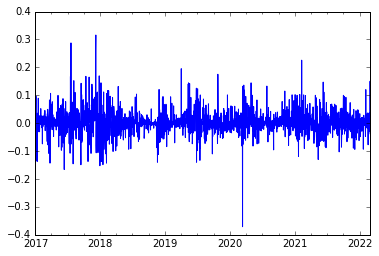

In [49]:
market_returns.plot()

<AxesSubplot:>

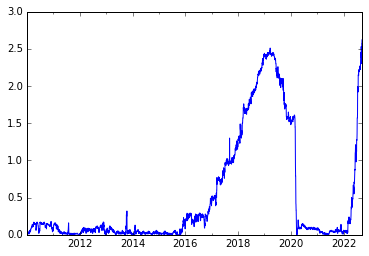

In [50]:
treasury_yield_rates["1 Mo"].plot()

<AxesSubplot:>

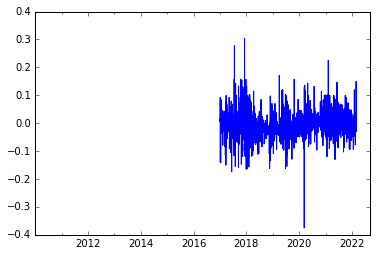

In [51]:
excess_market_returns.plot()

<AxesSubplot:>

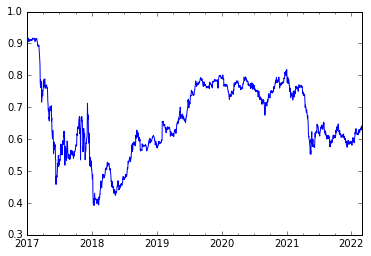

In [52]:
value_weights.BTC.plot()

In [53]:
market_returns[market_returns > 2]

Series([], dtype: float64)

## capm $\beta$

The market beta calculated based on a 30-day rolling window. We follow Lewellen and Nagel (2006) and calculate the beta as the sum of the coefficients of daily returns on the market excess return and one lag of the market excess returns. The market portfolio is calculated as the value-weighted average of the asset returns available at each day t.

## First data point on the 31. day where prices are available for a coin

"Second, and more important, nonsynchronous price movements can have a big impact on short-horizon betas. Lo and MacKinlay (1990) show that small stocks tend to react with a week or more delay to common news, so a daily or weekly beta will miss much of the small-stock covariance with market returns. To mitigate this problem, our tests focus on value-weighted portfolios and exclude NASDAQ stocks. Also, following Dimson (1979), we include both current and lagged market returns in the regressions, estimating beta as the sum of the slopes on all lags (alpha is still just the intercept). For daily returns, we include four lags of market returns, imposing the constraint that lags 2–4 have the same slope to reduce the number of parameters:"

$R_{i,t} = \alpha_i + \beta_{i0}R_{M,t} + \beta_{i1}R_{M,t-1} + \beta_{i2}[(R_{M,t-2} + R_{M,t-3} + R_{M,t-4})/3]$

"The daily beta is then $\beta_i = \beta_{i0} +\beta_{i1} +\beta_{i2} $. (Adding a few more lags doesn’t affect the
results.) For weekly returns, we include two lags of market returns:"

In [54]:
# Suppress runtime warnings
import warnings
warnings.filterwarnings("ignore")
# Cycle through all the coins
for coin in tqdm(aggregate_data.keys()):
    # Create empty column where we will insert data
    aggregate_data[coin]["capm beta"] = np.nan
    aggregate_data[coin]["capm alpha"] = np.nan
    aggregate_data[coin]["ivol"] = np.nan

    # One regression per rolling window of size 30 days:
    windowsize = 30

    # How many windows?
    m = len(aggregate_data[coin]) - windowsize + 1

    for i in np.arange(m):
        # Don't start on first day since there is no return, instead start on day 2
        days_0_lag = aggregate_data[coin]["daily excess return"].iloc[i + 1 : i+31].index
        days_1_lag = aggregate_data[coin]["daily excess return"].iloc[i + 0 : i+30].index
        x0 = excess_market_returns.loc[days_0_lag].reset_index(drop = True)
        x1 = excess_market_returns.loc[days_1_lag].reset_index(drop = True)
        X = pd.concat([x0, x1], axis = 1)
        X = sm.add_constant(X)

        # Also start on day 2
        y = aggregate_data[coin]["daily excess return"].iloc[i + 1:i+31].reset_index(drop = True)
        if any(1 - np.isnan(y)) and any(1 - np.isnan(X)):
            try:
                model = sm.OLS(y, X, missing='drop')
            except:
                beta = np.nan
                alpha = np.nan
                ivol = np.nan
            else:
                try:
                    results = model.fit()
                except:
                    beta = np.nan
                    alpha = np.nan
                    ivol = np.nan
                else:
                    try:
                        beta = results.params[0] + results.params[1]
                        alpha = results.params["const"]
                        ivol = np.nanstd(y - results.predict(X))
                    except:
                        beta = np.nan
                        alpha = np.nan
                        ivol = np.nan

            aggregate_data[coin].loc[days_0_lag[-1], "capm beta"] = beta
            aggregate_data[coin].loc[days_0_lag[-1], "capm alpha"] = alpha
            aggregate_data[coin].loc[days_0_lag[-1], "ivol"] = ivol




100%|██████████| 322/322 [18:46<00:00,  3.50s/it]  


<AxesSubplot:xlabel='day'>

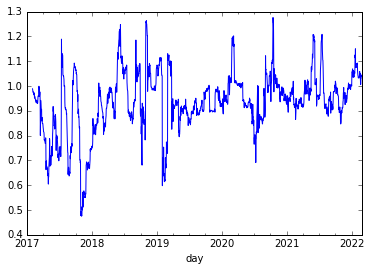

In [55]:
aggregate_data["BTC"]["capm beta"].plot()

<AxesSubplot:xlabel='day'>

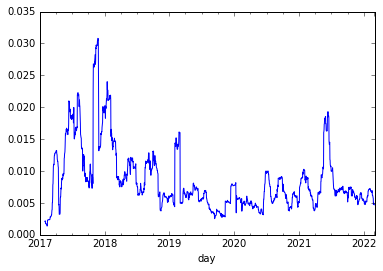

In [56]:
aggregate_data["BTC"]["ivol"].plot()


<AxesSubplot:xlabel='day'>

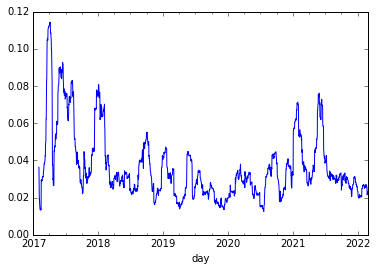

In [57]:
aggregate_data["ETH"]["ivol"].plot()


## capm $\alpha$ all clear

Done simultaneously with ivol and beta.

# ivol. all clear

The standard deviation from the residuals from a CAPM regression calculated based on a 30-day rolling window (see description of the capm β).

Done simultaneously with alpha and beta.

# turnover.

Turnover is last day’s trading volume in $ over the current supply (see Datar et al., 1998). The current available supply is calculated as the current supply minus the coins that have been burned.

In [58]:
for coin in tqdm(aggregate_data.keys()):
    # Create empty column where we will insert data
    aggregate_data[coin]["turnover"] = aggregate_data[coin]["volume"].shift(1) / aggregate_data[coin]["current_supply"]

100%|██████████| 322/322 [00:00<00:00, 3279.55it/s]


<AxesSubplot:xlabel='day'>

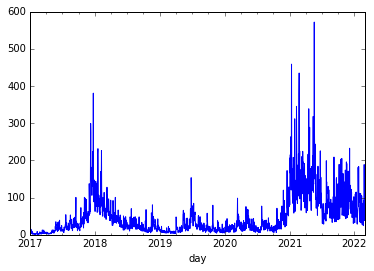

In [59]:
aggregate_data["BTC"]["turnover"].plot()

# rvol.

We follow Yang and Zhang (2000) and calculate the daily realised volatility calculated based on daily OHLC prices.

Window size of 30 according to Bianchi & Babiak.

In [60]:
aggregate_data["BTC"]

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timestamp,...,volume,exclude_testing,exclude_training_and_testing,bm,size,illiq,capm beta,capm alpha,ivol,turnover
day,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1483228800,1001.61,956.10,963.38,41148.52,4.057092e+07,995.44,direct,NaN,2017-01-01 01:00:00,...,4.096088e+07,False,False,0.013175,1.600404e+10,-8.307533e-08,NaN,NaN,NaN,NaN
2017-01-02,1483315200,1031.68,990.20,995.44,64951.63,6.603807e+07,1017.05,direct,NaN,2017-01-02 01:00:00,...,6.605906e+07,False,False,0.012915,1.635349e+10,-5.797886e-08,NaN,NaN,NaN,2.547423
2017-01-03,1483401600,1035.47,1006.53,1017.05,54788.01,5.608587e+07,1033.30,direct,NaN,2017-01-03 01:00:00,...,5.661245e+07,False,False,0.012732,1.661690e+10,-7.306818e-08,NaN,NaN,NaN,4.107795
2017-01-04,1483488000,1148.54,1022.32,1033.30,156272.17,1.705846e+08,1135.41,direct,NaN,2017-01-04 01:00:00,...,1.774330e+08,False,False,0.011608,1.826114e+10,-1.304415e-08,NaN,NaN,NaN,3.519952
2017-01-05,1483574400,1150.63,874.53,1135.41,240007.84,2.448393e+08,989.35,direct,NaN,2017-01-05 01:00:00,...,2.374518e+08,False,False,0.013342,1.591375e+10,-8.636414e-09,NaN,NaN,NaN,11.030924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-25,1645747200,39710.26,38043.51,38353.62,39454.29,1.536576e+09,39239.77,direct,NaN,2022-02-25 01:00:00,...,1.548177e+09,False,False,0.001293,7.443181e+11,-2.433648e-09,1.041192,-0.000333,0.004976,188.748089
2022-02-26,1645833600,40228.13,38605.65,39239.77,18649.99,7.329960e+08,39134.83,direct,NaN,2022-02-26 01:00:00,...,7.298642e+08,False,False,0.001297,7.423547e+11,-8.116657e-09,1.042503,-0.000077,0.004801,81.615506
2022-02-27,1645920000,39861.91,37039.71,39134.83,30834.07,1.184510e+09,37714.96,direct,NaN,2022-02-27 01:00:00,...,1.162906e+09,False,False,0.001347,7.154530e+11,-2.851863e-09,1.044346,-0.000507,0.004726,38.474642


In [61]:
# Cycle through all the coins
for coin in tqdm(aggregate_data.keys()):
    # Create empty column where we will insert data
    aggregate_data[coin]["rvol"] = np.nan

    # One regression per rolling window of size 30 days:
    windowsize = 30

    # How many windows?
    m = len(aggregate_data[coin]) - windowsize + 1

    for i in np.arange(m):
        # Don't start on first day since we need previous day's prices to normalize, instead start on day 2
        days_0_lag = aggregate_data[coin]["daily excess return"].iloc[i + 1 : i+31].index
        days_1_lag = aggregate_data[coin]["daily excess return"].iloc[i + 0 : i+30].index

        # To normalize the prices we sometimes need information from the current day, sometimes from the previous
        # We shift the indices of the 'previous' variable back after retrieving the information so that yesterday's information is matched to today
        close_previous = aggregate_data[coin].loc[days_1_lag, "close"]
        close_previous.index = close_previous.index + timedelta(days = 1)

        close_current = aggregate_data[coin].loc[days_0_lag, "close"]

        open_current = aggregate_data[coin].loc[days_0_lag, "open"]

        high_current = aggregate_data[coin].loc[days_0_lag, "high"]

        low_current = aggregate_data[coin].loc[days_0_lag, "low"]

        # Normalize prices
        open_normalized = np.log(open_current) - np.log(close_previous)
        high_normalized = np.log(high_current) - np.log(open_current)
        low_normalized = np.log(low_current) - np.log (open_current)
        close_normalized = np.log(close_current) - np.log(open_current)

        # First estimator
        V_O = 1 / (windowsize - 1) * ((open_normalized - open_normalized.mean())**2).sum()

        # Second estimator
        V_C = 1 / (windowsize - 1) * ((close_normalized - close_normalized.mean())**2).sum()

        # Third estimator
        V_RS = 1 / windowsize * (high_normalized * (high_normalized - close_normalized) + low_normalized * (low_normalized - close_normalized)).sum()

        # Weighing constant k
        # Authors suggest to set alpha to 1.34 in practice
        alpha = 1.34
        k = (alpha - 1) / (alpha + (windowsize + 1) / (windowsize - 1))

        # Final, weighted estimator
        V = V_O + k * V_C + (1 - k) * V_RS
        aggregate_data[coin].loc[days_0_lag[-1], "rvol"] = V

100%|██████████| 322/322 [12:39<00:00,  2.36s/it]


<AxesSubplot:xlabel='day'>

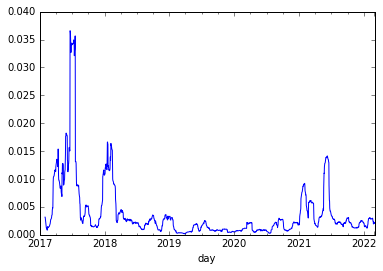

In [62]:
aggregate_data["ETH"].rvol.plot()

# bid-ask.

The bid-ask spread is the average of two alternative synthetic approximations based on OHLC prices by Abdi and Ranaldo (2017) and Corwin and Schultz (2012). On a given day and for a given cryptocurrency pair we calculate both proxies and take the simple average between the two.

In [63]:
for coin in tqdm(aggregate_data.keys()):
    high_prices = aggregate_data[coin]["high"]
    low_prices = aggregate_data[coin]["low"]
    close_prices = aggregate_data[coin]["close"]
    aggregate_data[coin]["S Corwin Schultz interval with previous day"] = np.nan
    aggregate_data[coin]["S Abdi Ranaldo interval with previous day"] = np.nan

    # Corwin and Schultz
    for id in high_prices.index[1:]:
        high_current = high_prices.loc[id]
        high_previous = high_prices.shift(1).loc[id]

        low_current = low_prices.loc[id]
        low_previous = low_prices.shift(1).loc[id]

        high_over_two_days = np.max([high_current, high_previous])
        low_over_two_days = np.min([low_current, low_previous])

        # Highs and lows over two consecutive days
        gamma = np.log(high_over_two_days / low_over_two_days) ** 2
        # Single highs and lows of two consecutive days
        beta = np.sum([np.log(high_current / low_current) ** 2, np.log(high_previous / low_previous) ** 2])

        alpha = (np.sqrt(2 * beta) - np.sqrt(beta) ) / (3 - 2 * np.sqrt(2)) - np.sqrt(gamma / (3 - 2 * np.sqrt(2)))

        S = 2 * (np.exp(alpha) - 1) / (1 + np.exp(alpha))

        # Save only positive estimates (Adjustment C in original paper)
        aggregate_data[coin].loc[id, "S Corwin Schultz interval with previous day"] = np.max([S,0])



    # Abdi and Ranaldo:

    for id in close_prices.index[1:]:
        # Log of close prices of current and future day
        log_close_current = np.log(close_prices.loc[id])

        # Mid ranges
        log_mid_range_current = (np.log(low_prices.loc[id]) + np.log(high_prices.loc[id])) / 2
        log_mid_range_previous = (np.log(low_prices.shift(1).loc[id]) + np.log(high_prices.shift(1).loc[id])) / 2

        # Actual estimate
        s_t = np.sqrt(np.max([4 * (log_close_current - log_mid_range_current) * (log_close_current - log_mid_range_previous), 0]))

        aggregate_data[coin].loc[id, "S Abdi Ranaldo interval with previous day"] = s_t

    # These are all estimates over two-day intervals
    # To get daily estimates take the average of the two intervals that intersect on a given day (see internet apendix of original paper by Corwin Schultz)

    aggregate_data[coin]["S Corwin Schultz"] = aggregate_data[coin]["S Corwin Schultz interval with previous day"]
    aggregate_data[coin].loc[aggregate_data[coin].index[1:-1], "S Corwin Schultz"] = (aggregate_data[coin].loc[aggregate_data[coin].index[1:-1], "S Corwin Schultz interval with previous day"] + aggregate_data[coin].loc[aggregate_data[coin].index[1:], "S Corwin Schultz interval with previous day"].shift(-1)) / 2

    aggregate_data[coin]["S Abdi Ranaldo"] = aggregate_data[coin]["S Abdi Ranaldo interval with previous day"]
    aggregate_data[coin].loc[aggregate_data[coin].index[1:-1], "S Abdi Ranaldo"] = (aggregate_data[coin].loc[aggregate_data[coin].index[1:-1], "S Abdi Ranaldo interval with previous day"] + aggregate_data[coin].loc[aggregate_data[coin].index[1:], "S Abdi Ranaldo interval with previous day"].shift(-1)) / 2

    # Average of both estimators
    aggregate_data[coin]["bid-ask"] = np.nanmean([aggregate_data[coin]["S Corwin Schultz"],aggregate_data[coin]["S Abdi Ranaldo"]], axis = 0)

    del aggregate_data[coin]["S Corwin Schultz interval with previous day"]
    del aggregate_data[coin]["S Abdi Ranaldo interval with previous day"]



100%|██████████| 322/322 [02:17<00:00,  2.33it/s]


In [64]:
aggregate_data.keys()

dict_keys(['FREC', 'CAPP', 'KICK', 'WAN', 'LTO', 'ADX', 'DRGN', 'DAG', 'DCN', 'MGO', 'STORJ', 'TOMO', 'BCH', 'BMC', 'UBT', 'SENT', 'YOYOW', 'BTC', 'OPEN', 'DTR', 'CSP', 'VEE', 'DLT', 'MDA', 'NEXT', 'J8T', 'LAMB', 'SOC', 'ZINC', 'DADI', 'BTU', 'XAUR', 'RDD', 'BAT', 'PPT', 'PRO', 'NTK', 'BETR', 'UTK', 'ELIX', 'IHT', 'SOMA', 'TAAS', 'STORM', 'MDS', 'SNC', 'ADH', 'VIBE', 'PASS', 'SVD', 'NCC', 'EKT', 'REP', 'EDN', 'IDT', 'LYM', 'LUN', 'KRL', 'MWAT', 'TSL', 'ODE', 'VET', 'ZSC', 'AEN', 'AXPR', 'AST', 'CEL', 'FXT', 'TFL', 'TDS', 'SAN', 'FYP', 'DAT', 'JNT', 'ZIL', 'CV', 'SWT', 'STX', 'BELA', 'PLBT', 'CHAT', 'EGT', 'REQ', 'QASH', 'BLOC', 'OAX', 'DGD', 'HIT', 'AMB', 'ANKR', 'UQC', 'UPP', 'BANCA', 'NCASH', 'ENJ', 'CHSB', 'CTXC', 'OMX', 'FOAM', 'MTX', 'FLIXX', 'AAC', 'POLY', 'CNN', 'BSTN', 'HPB', 'TNB', 'CMT', 'VIDT', 'DRG', 'POWR', 'INS', 'EVX', 'RCT', 'ORME', 'GNX', 'ETC', 'BSV', 'GNO', 'MANA', 'SRN', 'XNK', 'CCL', 'ZLA', 'MNE', 'SKM', 'ZAP', 'SCRL', 'SNGLS', 'PAL', 'LPT', 'PNT', 'SNTVT', 'BRD', 

In [65]:
aggregate_data["BTC"]

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timestamp,...,size,illiq,capm beta,capm alpha,ivol,turnover,rvol,S Corwin Schultz,S Abdi Ranaldo,bid-ask
day,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1483228800,1001.61,956.10,963.38,41148.52,4.057092e+07,995.44,direct,NaN,2017-01-01 01:00:00,...,1.600404e+10,-8.307533e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,1483315200,1031.68,990.20,995.44,64951.63,6.603807e+07,1017.05,direct,NaN,2017-01-02 01:00:00,...,1.635349e+10,-5.797886e-08,NaN,NaN,NaN,2.547423,NaN,0.006243,0.031836,0.019039
2017-01-03,1483401600,1035.47,1006.53,1017.05,54788.01,5.608587e+07,1033.30,direct,NaN,2017-01-03 01:00:00,...,1.661690e+10,-7.306818e-08,NaN,NaN,NaN,4.107795,NaN,0.006243,0.086801,0.046522
2017-01-04,1483488000,1148.54,1022.32,1033.30,156272.17,1.705846e+08,1135.41,direct,NaN,2017-01-04 01:00:00,...,1.826114e+10,-1.304415e-08,NaN,NaN,NaN,3.519952,NaN,0.028572,0.105940,0.067256
2017-01-05,1483574400,1150.63,874.53,1135.41,240007.84,2.448393e+08,989.35,direct,NaN,2017-01-05 01:00:00,...,1.591375e+10,-8.636414e-09,NaN,NaN,NaN,11.030924,NaN,0.067144,0.117762,0.092453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-25,1645747200,39710.26,38043.51,38353.62,39454.29,1.536576e+09,39239.77,direct,NaN,2022-02-25 01:00:00,...,7.443181e+11,-2.433648e-09,1.041192,-0.000333,0.004976,188.748089,0.001193,0.004353,0.025309,0.014831
2022-02-26,1645833600,40228.13,38605.65,39239.77,18649.99,7.329960e+08,39134.83,direct,NaN,2022-02-26 01:00:00,...,7.423547e+11,-8.116657e-09,1.042503,-0.000077,0.004801,81.615506,0.001173,0.006294,0.028621,0.017458
2022-02-27,1645920000,39861.91,37039.71,39134.83,30834.07,1.184510e+09,37714.96,direct,NaN,2022-02-27 01:00:00,...,7.154530e+11,-2.851863e-09,1.044346,-0.000507,0.004726,38.474642,0.001198,0.007314,0.113897,0.060606


# dto. relatively clear ("coins that have been burned")

We follow the logic in Garfinkel (2009) and define de-trended turnover as the ratio of daily volume in $ to current available supply, minus the daily market turnover and de-trend it by its 180 trading day median. The daily market turnover is a value-weighed aggregation of the individual assets’ turnover.

In [66]:
# Create empty dataframe to save turnovers of all coins
turnovers = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())

# Fill it with data
for coin in tqdm(turnovers.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        turnovers.loc[index, coin] = aggregate_data[coin].loc[index, "turnover"]


100%|██████████| 322/322 [00:14<00:00, 22.15it/s]


In [67]:
# Turnover of value-weighted market portfolio
market_turnover = value_weights.multiply(turnovers, axis = 1).sum(axis = 1)

In [68]:
# Market adjusted turnover is individual turnover minus the whole market's turnover
market_adjusted_turnovers = turnovers.subtract(market_turnover, axis = 0)

In [69]:
# The market adjusted turnover is detrended by subtracting the median of the previous 180 days (rolling window approach)
# So first we calculate this median
past_median_market_adjusted_turnovers = pd.DataFrame(index = market_adjusted_turnovers.index, columns = market_adjusted_turnovers.columns)

# 2 cases: we either have at least 180 days before the current time point or we do not
# Every coin can start at a different date, so we calculate this coin by coin

for coin in tqdm(market_adjusted_turnovers.columns):
    # First day where coin has turnover?
    firstday = market_adjusted_turnovers[coin].notna().idxmax()

    # Last day where coin has turnover?
    lastday = market_adjusted_turnovers[coin][::-1].notna().idxmax()

    windowrange = 180

    # Case if we have less than 180 observations IN TOTAL
    if len(market_adjusted_turnovers.loc[firstday : lastday, coin]) + 1 <= 180:
        windowrange = len(market_adjusted_turnovers.loc[firstday : lastday, coin]) + 1

    # Now succesively populate next medians
    for i in np.arange(windowrange):
        past_median_market_adjusted_turnovers.loc[firstday + timedelta(days = int(i)), coin] = np.median(market_adjusted_turnovers.loc[firstday : firstday + timedelta(days = int(i + 1)), coin])

    # Continue if we have more than 180 observations
    if len(market_adjusted_turnovers.loc[firstday : lastday, coin]) > 180:
        for i in np.arange(windowrange, len(market_adjusted_turnovers.loc[firstday : lastday, coin]) + 1):
            past_median_market_adjusted_turnovers.loc[firstday + timedelta(days = int(i)), coin] = np.median(market_adjusted_turnovers.loc[firstday + timedelta(days = int(i + 1 - 180)) : firstday + timedelta(days = int(i + 1)), coin])



100%|██████████| 322/322 [00:57<00:00,  5.56it/s]


In [70]:
# Detrended turnover is market adjusted turnover minus its past 180 days' median

detrended_turnover = market_adjusted_turnovers - past_median_market_adjusted_turnovers

In [71]:
# Save results back
for coin in tqdm(detrended_turnover.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        aggregate_data[coin].loc[index, "detrended turnover"] =  detrended_turnover.loc[index, coin]

100%|██████████| 322/322 [00:18<00:00, 17.77it/s]


# std to. ???

The standard deviation of the residuals from a 30-day rolling window regression of daily turnover on a constant (see Chordia et al., 2001).

Maybe: "Further, for all of the regressions reported below, the transformed "rm characteristic variables for a given month were expressed as deviations from their cross-sectional means for that month; this implies that the average security will have values of each non-risk characteristic that are equal to zero, so that under both the null and the alternative hypotheses its expected return will be determined solely by its risk characteristics."

In [72]:
# Union of all values in the days column
all_days_sorted = my.sort_all_times([aggregate_data[key] for key in aggregate_data.keys()])

# Create empty dataframe to save turnovers of all coins
turnovers = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())

# Fill it with data
for coin in tqdm(turnovers.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        turnovers.loc[index, coin] = aggregate_data[coin].loc[index, "turnover"]


100%|██████████| 322/322 [00:15<00:00, 21.13it/s]


In [73]:
# Create empty dataframe to save standard deviation of turnovers of all coins
std_turnovers = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())

In [74]:
for coin in tqdm(std_turnovers.columns):
    # Create 30 copies of turnovers of this coin and save as columns of a dataframe. Each column is lagged by an incremental amount of days (0 to 29)
    # Due to rolling window approach of size 30
    lagged_turnovers = pd.DataFrame({i: turnovers[coin].shift(i) for i in np.arange(30)})
    # New column with rowwise standard deviation
    lagged_turnovers["std"] = np.std(lagged_turnovers, axis = 1)
    # Save back to dataframe with all standard deviations for all coins
    std_turnovers[coin] = lagged_turnovers["std"]

100%|██████████| 322/322 [00:06<00:00, 51.94it/s]


In [75]:
# Save results back
for coin in tqdm(std_turnovers.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        aggregate_data[coin].loc[index, "standard deviation turnover"] =  std_turnovers.loc[index, coin]

100%|██████████| 322/322 [00:18<00:00, 17.65it/s]


# std vol. ???

The standard deviation of the residuals from a regression of daily trading volume on a constant (see Chordia et al., 2001).

In [76]:
# Union of all values in the days column
all_days_sorted = my.sort_all_times([aggregate_data[key] for key in aggregate_data.keys()])

# Create empty dataframe to save turnovers of all coins
daily_trading_volumes = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())

# Fill it with data
for coin in tqdm(daily_trading_volumes.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        daily_trading_volumes.loc[index, coin] = aggregate_data[coin].loc[index, "volume"]


100%|██████████| 322/322 [00:14<00:00, 21.99it/s]


In [77]:
# Create empty dataframe to save standard deviation of turnovers of all coins
std_volumes = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())

In [78]:
for coin in tqdm(std_volumes.columns):
    # Create 30 copies of trading volumes of this coin and save as columns of a dataframe. Each column is lagged by an incremental amount of days (0 to 29)
    # Due to rolling window approach of size 30
    lagged_volumes = pd.DataFrame({i: daily_trading_volumes[coin].shift(i) for i in np.arange(30)})
    # New column with rowwise standard deviation
    lagged_volumes["std"] = np.std(lagged_volumes, axis = 1)
    # Save back to dataframe with all standard deviations for all coins
    std_volumes[coin] = lagged_volumes["std"]

100%|██████████| 322/322 [00:06<00:00, 53.53it/s]


In [79]:
# Save results back
for coin in tqdm(std_volumes.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        aggregate_data[coin].loc[index, "standard deviation volume"] =  std_volumes.loc[index, coin]

100%|██████████| 322/322 [00:18<00:00, 17.89it/s]


# rel to high. all clear

Closeness to 90-day high is the ratio of the cryptocurrency price at the end of the previous day and the previous 90-day high. This adapts to a shorter time span the logic in George and Hwang (2004).

In [80]:
# Union of all values in the days column
all_days_sorted = my.sort_all_times([aggregate_data[key] for key in aggregate_data.keys()])

# Create empty dataframe to save close prices of all coins
close_prices = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())

# Fill it with data
for coin in tqdm(close_prices.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        close_prices.loc[index, coin] = aggregate_data[coin].loc[index, "close"]


100%|██████████| 322/322 [00:14<00:00, 21.86it/s]


In [81]:
# Create empty dataframe to save rel to high of all coins
rel_to_high = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())

In [82]:
for coin in tqdm(std_volumes.columns):
    # Create 90 copies of close prices of this coin and save as columns of a dataframe. Each column is lagged by an incremental amount of days (1 to 90)
    # Since we need maximum of last 90 days
    lagged_close_prices = pd.DataFrame({i: close_prices[coin].shift(i) for i in np.arange(1, 91)})
    # New column with rel to high
    lagged_close_prices["rel_to_high"] = lagged_close_prices[1] / np.max(lagged_close_prices, axis = 1).replace(0, np.nan)
    # Save back to dataframe with all rel to high for all coins
    rel_to_high[coin] = lagged_close_prices["rel_to_high"]

100%|██████████| 322/322 [00:06<00:00, 47.77it/s]


In [83]:
# Save results back
for coin in tqdm(rel_to_high.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        aggregate_data[coin].loc[index, "rel to high"] =  rel_to_high.loc[index, coin]

100%|██████████| 322/322 [00:17<00:00, 17.96it/s]


# max. all clear

Maximum daily return in the previous month following Bali et al. (2011).

In [84]:
# Union of all values in the days column
all_days_sorted = my.sort_all_times([aggregate_data[key] for key in aggregate_data.keys()])

# Create empty dataframe to save returns of all coins
daily_returns = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())

# Fill it with data
for coin in tqdm(daily_returns.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        daily_returns.loc[index, coin] = aggregate_data[coin].loc[index, "daily excess return"]


100%|██████████| 322/322 [00:14<00:00, 22.03it/s]


In [85]:
# Create empty dataframe to save rel to high of all coins
max_return_one_month = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())

In [86]:
for coin in tqdm(std_volumes.columns):
    # Create 30 copies of excess returns of this coin and save as columns of a dataframe. Each column is lagged by an incremental amount of days (0 to 29)
    # Since we need maximum of last 30 days
    lagged_returns = pd.DataFrame({i: daily_returns[coin].shift(i) for i in np.arange(30)})
    # New column with rel to high
    lagged_returns["max"] = np.max(lagged_returns, axis = 1)
    # Save back to dataframe with all max returns for all coins
    max_return_one_month[coin] = lagged_returns["max"]

100%|██████████| 322/322 [00:02<00:00, 122.37it/s]


In [87]:
# Save results back
for coin in tqdm(max_return_one_month.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        aggregate_data[coin].loc[index, "max"] =  max_return_one_month.loc[index, coin]

100%|██████████| 322/322 [00:17<00:00, 18.05it/s]


# vol shock ld. all clear

We follow Llorente et al. (2002) and construct the log deviation of trading volume from its trend estimated over a rolling period of l = 30,60 days. The log standard deviation computed over the same rolling window is used to standardise the estimates due to cross-sectional imbalances (see Babiak et al., 2022).

In [88]:
# Union of all values in the days column
all_days_sorted = my.sort_all_times([aggregate_data[key] for key in aggregate_data.keys()])

# Create empty dataframe to save turnovers of all coins
daily_trading_volumes = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())

# Fill it with data
for coin in tqdm(daily_trading_volumes.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        daily_trading_volumes.loc[index, coin] = aggregate_data[coin].loc[index, "volume"]


100%|██████████| 322/322 [00:14<00:00, 22.40it/s]


## 30 days first

In [89]:
# Create empty dataframe to save standard deviation of turnovers of all coins
vol_shock = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())

In [90]:
# Suppress runtime warnings
import warnings
warnings.filterwarnings("ignore")

In [91]:
for coin in tqdm(vol_shock.columns):
    # Create 30 copies of trading volumes of this coin and save as columns of a dataframe. Each column is lagged by an incremental amount of days (0 to 30)
    # Due to rolling window approach of size 30
    lagged_volumes = pd.DataFrame({i: daily_trading_volumes[coin].shift(i) for i in np.arange(31)})
    # New column with rowwise standard deviation
    lagged_volumes["volume_shock"] = (np.log(lagged_volumes.loc[:, 0].astype(float)) - np.log((np.mean(lagged_volumes.loc[:, 1:30], axis = 1) / 30)).astype(float)) / np.log(np.std(lagged_volumes.loc[:, 1:30], axis = 1).astype(float))
    # Save back to dataframe with all standard deviations for all coins
    vol_shock[coin] = lagged_volumes["volume_shock"]

100%|██████████| 322/322 [00:08<00:00, 39.82it/s]


In [92]:
# Save results back
for coin in tqdm(vol_shock.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        aggregate_data[coin].loc[index, "volume shock 30"] =  vol_shock.loc[index, coin]

100%|██████████| 322/322 [00:17<00:00, 17.92it/s]


## Now 60 days

In [93]:
# Create empty dataframe to save standard deviation of turnovers of all coins
vol_shock_60 = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())

In [94]:
# Suppress runtime warnings
import warnings
warnings.filterwarnings("ignore")

In [95]:
for coin in tqdm(vol_shock.columns):
    # Create 30 copies of trading volumes of this coin and save as columns of a dataframe. Each column is lagged by an incremental amount of days (0 to 60)
    # Due to rolling window approach of size 60
    lagged_volumes = pd.DataFrame({i: daily_trading_volumes[coin].shift(i) for i in np.arange(61)})
    # New column with rowwise standard deviation
    lagged_volumes["volume_shock"] = (np.log(lagged_volumes.loc[:, 0].astype(float)) - np.log((np.mean(lagged_volumes.loc[:, 1:60], axis = 1) / 60)).astype(float)) / np.log(np.std(lagged_volumes.loc[:, 1:60], axis = 1).astype(float))
    # Save back to dataframe with all standard deviations for all coins
    vol_shock_60[coin] = lagged_volumes["volume_shock"]

100%|██████████| 322/322 [00:16<00:00, 20.01it/s]


In [96]:
# Save results back
for coin in tqdm(vol_shock.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        aggregate_data[coin].loc[index, "volume shock 60"] =  vol_shock_60.loc[index, coin]

100%|██████████| 322/322 [00:18<00:00, 17.67it/s]


# Reversals

Variety of cumulative returns.



In [97]:
# Union of all values in the days column
all_days_sorted = my.sort_all_times([aggregate_data[key] for key in aggregate_data.keys()])

# Create empty dataframe to save close prices of all coins
close_prices = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())

# Fill it with data
for coin in tqdm(close_prices.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        close_prices.loc[index, coin] = aggregate_data[coin].loc[index, "close"]


100%|██████████| 322/322 [00:14<00:00, 22.12it/s]


In [98]:
# Create empty dataframes to save various time horizon returns
r2_1 = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())
r7_2 = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())
r13_2 = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())
r22_2 = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())
r31_2 = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())
r30_14 = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())
r180_60 = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())


In [99]:
for coin in tqdm(close_prices.columns):
    # Create 181 copies of close prices of this coin and save as columns of a dataframe. Each column is lagged by a different amount of days
    lagged_close_prices = pd.DataFrame({i: close_prices[coin].shift(i) for i in [1, 2, 7, 13, 22, 31, 14, 30,60, 180]})
    # New columns with reversals
    lagged_close_prices["r2_1"] = 1 - lagged_close_prices[2] / lagged_close_prices[1]
    lagged_close_prices["r7_2"] = 1 - lagged_close_prices[7] / lagged_close_prices[2]
    lagged_close_prices["r13_2"] = 1 - lagged_close_prices[13] / lagged_close_prices[2]
    lagged_close_prices["r22_2"] = 1 - lagged_close_prices[22] / lagged_close_prices[2]
    lagged_close_prices["r31_2"] = 1 - lagged_close_prices[31] / lagged_close_prices[2]
    lagged_close_prices["r30_14"] = 1 - lagged_close_prices[30] / lagged_close_prices[14]
    lagged_close_prices["r180_60"] = 1 - lagged_close_prices[180] / lagged_close_prices[60]
    # Save back to dataframes with reversals of all coins
    r2_1[coin] = lagged_close_prices["r2_1"]
    r7_2[coin] = lagged_close_prices["r7_2"]
    r13_2[coin] = lagged_close_prices["r13_2"]
    r22_2[coin] = lagged_close_prices["r22_2"]
    r31_2[coin] = lagged_close_prices["r31_2"]
    r30_14[coin] = lagged_close_prices["r30_14"]
    r180_60[coin] = lagged_close_prices["r180_60"]


100%|██████████| 322/322 [00:04<00:00, 72.58it/s] 


In [100]:
# Save results back
for coin in tqdm(r2_1.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        aggregate_data[coin].loc[index, "r2_1"] =  r2_1.loc[index, coin]
        aggregate_data[coin].loc[index, "r7_2"] =  r7_2.loc[index, coin]
        aggregate_data[coin].loc[index, "r13_2"] =  r13_2.loc[index, coin]
        aggregate_data[coin].loc[index, "r22_2"] =  r22_2.loc[index, coin]
        aggregate_data[coin].loc[index, "r31_2"] =  r31_2.loc[index, coin]
        aggregate_data[coin].loc[index, "r30_14"] =  r30_14.loc[index, coin]
        aggregate_data[coin].loc[index, "r180_60"] =  r180_60.loc[index, coin]

100%|██████████| 322/322 [02:04<00:00,  2.59it/s]


# VaR(5%). just empirical quantile?

The historical Value-at-Risk at 5% calculated based on past 90-day returns.

In [101]:
# Union of all values in the days column
all_days_sorted = my.sort_all_times([aggregate_data[key] for key in aggregate_data.keys()])

# Create empty dataframe to save returns of all coins
daily_returns = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())

# Fill it with data
for coin in tqdm(daily_returns.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        daily_returns.loc[index, coin] = aggregate_data[coin].loc[index, "daily excess return"]


100%|██████████| 322/322 [00:14<00:00, 22.02it/s]


In [102]:
# Create empty dataframe to save rel to high of all coins
var_5 = pd.DataFrame(index = all_days_sorted, columns = aggregate_data.keys())

In [103]:
for coin in tqdm(var_5.columns):
    # Create 30 copies of excess returns of this coin and save as columns of a dataframe. Each column is lagged by an incremental amount of days (0 to 89)
    # Since we need maximum of last 90 days
    lagged_returns = pd.DataFrame({i: daily_returns[coin].shift(i) for i in np.arange(90)}).fillna(np.nan)
    # New column with rel to high
    lagged_returns["var_5"] = np.quantile(lagged_returns, q = 0.05, axis = 1)
    # Save back to dataframe with all max returns for all coins
    var_5[coin] = lagged_returns["var_5"]

100%|██████████| 322/322 [00:09<00:00, 33.69it/s]


In [104]:
# Save results back
for coin in tqdm(var_5.columns):
    index_where_coin_has_data = aggregate_data[coin].index
    for index in index_where_coin_has_data:
        aggregate_data[coin].loc[index, "var_5"] =  var_5.loc[index, coin]

100%|██████████| 322/322 [00:18<00:00, 17.64it/s]


In [105]:
var_5.tail()

,FREC,CAPP,KICK,WAN,LTO,ADX,DRGN,DAG,DCN,MGO,...,DOV,ZRX,ADB,STQ,SUB,DOGE,BTM,BNT,BMX,MATIC
2022-02-25,0.0,-0.139981,0.0,-0.084533,NaN,-0.064474,-0.11459,-0.080151,-0.177328,0.0,...,-0.300117,-0.089632,-0.130479,0.0,-0.19656,-0.066826,-0.097257,-0.069159,-0.060722,-0.096733
2022-02-26,0.0,-0.139981,0.0,-0.084533,NaN,-0.064474,-0.11459,-0.080151,-0.181467,0.0,...,-0.300117,-0.089632,-0.130479,0.0,-0.19656,-0.066826,-0.097257,-0.069159,-0.060722,-0.096733
2022-02-27,0.0,-0.139981,0.0,-0.084533,NaN,-0.067941,-0.11459,-0.080151,-0.181467,0.0,...,-0.300117,-0.089632,-0.130479,0.0,-0.19656,-0.066826,-0.097257,-0.069159,-0.060722,-0.096733
2022-02-28,0.0,-0.139981,0.0,-0.084533,NaN,-0.067941,-0.11459,-0.080151,-0.181467,0.0,...,-0.300117,-0.089632,-0.130479,0.0,-0.19656,-0.066826,-0.097257,-0.069159,-0.060722,-0.096733
2022-03-01,0.0,-0.139981,0.0,-0.084533,NaN,-0.067941,-0.11459,-0.073160,-0.181467,0.0,...,-0.300117,-0.089632,-0.130479,0.0,-0.19656,-0.066826,-0.097257,-0.069159,-0.060722,-0.096733


# Save results

In [106]:
path_aggregate_data = "../Aggregate Data v3/"

for coin in aggregate_data.keys():
    aggregate_data[coin].to_csv(path_aggregate_data + coin + ".csv")

# Load results

In [107]:
path_aggregate_data = "../Aggregate Data v3/"

aggregate_data_files = os.listdir(path_aggregate_data)

aggregate_data = dict(
    zip(
        [file[:-4] for file in aggregate_data_files if file[-4:] == ".csv"],
        [pd.read_csv(path_aggregate_data + file, index_col="day") for file in aggregate_data_files if file[-4:] == ".csv"]
    )
)

for key in aggregate_data.keys():
    aggregate_data[key].index = pd.to_datetime(aggregate_data[key].index)

In [108]:
len(aggregate_data)

322

In [109]:
aggregate_data["BTC"]

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timestamp,...,volume shock 30,volume shock 60,r2_1,r7_2,r13_2,r22_2,r31_2,r30_14,r180_60,var_5
day,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1483228800,1001.61,956.10,963.38,41148.52,4.057092e+07,995.44,direct,NaN,2017-01-01 01:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,1483315200,1031.68,990.20,995.44,64951.63,6.603807e+07,1017.05,direct,NaN,2017-01-02 01:00:00,...,-0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,1483401600,1035.47,1006.53,1017.05,54788.01,5.608587e+07,1033.30,direct,NaN,2017-01-03 01:00:00,...,0.211534,0.253941,0.021248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,1483488000,1148.54,1022.32,1033.30,156272.17,1.705846e+08,1135.41,direct,NaN,2017-01-04 01:00:00,...,0.283596,0.326508,0.015726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,1483574400,1150.63,874.53,1135.41,240007.84,2.448393e+08,989.35,direct,NaN,2017-01-05 01:00:00,...,0.248564,0.287497,0.089932,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-25,1645747200,39710.26,38043.51,38353.62,39454.29,1.536576e+09,39239.77,direct,NaN,2022-02-25 01:00:00,...,0.174196,0.205057,0.028231,-0.073082,-0.133299,-0.001551,0.007911,0.131362,0.037868,-0.060775
2022-02-26,1645833600,40228.13,38605.65,39239.77,18649.99,7.329960e+08,39134.83,direct,NaN,2022-02-26 01:00:00,...,0.137914,0.167813,0.022583,-0.045719,-0.096894,-0.084392,0.039742,0.119538,0.011425,-0.060775
2022-02-27,1645920000,39861.91,37039.71,39134.83,30834.07,1.184510e+09,37714.96,direct,NaN,2022-02-27 01:00:00,...,0.162085,0.191384,-0.002681,0.021471,-0.084417,-0.055516,0.052241,0.102809,-0.014795,-0.060775
